code borrowed from 

    https://github.com/sjchoi86/yet-another-pytorch-tutorial/blob/main/notebook/mdn-cls.ipynb
    
# OOD CIFAR

In [7]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as TD
from torch.autograd import Variable
from collections import OrderedDict
from resnet import *
from resnet2 import *

%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)
print ("PyTorch version:[%s]."%(torch.__version__))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("device:[%s]."%(device))

PyTorch version:[1.6.0].
device:[cuda:0].


# Config

In [20]:
indist_dataset  = "cifar40"  #mnist, cifar40, cifar10
outdist_dataset = "cifar60"  #svhn, cifar60
measure         = "epis"     #confidence, epis, alea
resnet_layers   = "resnet20"
BATCH_SIZE = 128

# MLN

In [9]:
class MixtureOfLogits(nn.Module):
    def __init__(self,
                 in_dim     = 64,   # input feature dimension 
                 y_dim      = 10,   # number of classes 
                 k          = 5,    # number of mixtures
                 sig_min    = 1e-4, # minimum sigma
                 sig_max    = None, # maximum sigma
                 SHARE_SIG  = True  # share sigma among mixture
                 ):
        super(MixtureOfLogits,self).__init__()
        self.in_dim     = in_dim    # Q
        self.y_dim      = y_dim     # D
        self.k          = k         # K
        self.sig_min    = sig_min
        self.sig_max    = sig_max
        self.SHARE_SIG  = SHARE_SIG
        self.build_graph()

    def build_graph(self):
        self.h_dim = 256
        self.fc_pi      = nn.Sequential(nn.BatchNorm1d(self.in_dim),
                                        nn.Linear(self.in_dim,self.h_dim),
                                        nn.ReLU(inplace=True),
                                        nn.BatchNorm1d(self.h_dim),
                                        nn.Linear(self.h_dim,self.k))
                                        
        self.fc_mu      = nn.Sequential(nn.BatchNorm1d(self.in_dim),
                                        nn.Linear(self.in_dim,self.h_dim),
                                        nn.ReLU(inplace=True),
                                        nn.BatchNorm1d(self.h_dim),
                                        nn.Linear(self.h_dim,self.k*self.y_dim))
        if self.SHARE_SIG:
            self.fc_sigma   = nn.Sequential(nn.BatchNorm1d(self.in_dim),
                                        nn.Linear(self.in_dim,self.h_dim),
                                        nn.ReLU(inplace=True),
                                        nn.BatchNorm1d(self.h_dim),
                                        nn.Linear(self.h_dim,self.k))
        else:
            self.fc_sigma   = nn.Sequential(nn.BatchNorm1d(self.in_dim),
                                        nn.Linear(self.in_dim,self.h_dim),
                                        nn.ReLU(inplace=True),
                                        nn.BatchNorm1d(self.h_dim),
                                        nn.Linear(self.h_dim,self.k))

    def forward(self,x):
        """
            :param x: [N x Q]
        """
        pi_logit        = self.fc_pi(x)                                 # [N x K]
        pi              = torch.softmax(pi_logit,dim=1)                 # [N x K]
        mu              = self.fc_mu(x)                                 # [N x KD]
        mu              = torch.reshape(mu,(-1,self.k,self.y_dim))      # [N x K x D]
        mu              = F.sigmoid(mu)
        #mu              = F.softmax(mu, dim=-1)
        if self.SHARE_SIG:
            sigma       = self.fc_sigma(x)                              # [N x K]
            sigma       = sigma.unsqueeze(dim=-1)                       # [N x K x 1]
            sigma       = sigma.expand_as(mu)                           # [N x K x D]
        else:
            sigma       = self.fc_sigma(x)                              # [N x KD]
        sigma           = torch.reshape(sigma,(-1,self.k,self.y_dim))   # [N x K x D]
        if self.sig_max is None:
            sigma = self.sig_min + torch.exp(sigma)                     # [N x K x D]
        else:
            sig_range = (self.sig_max-self.sig_min)
            sigma = self.sig_min + sig_range*torch.sigmoid(sigma)       # [N x K x D]
        mol_out = {'pi':pi,'mu':mu,'sigma':sigma}
        return mol_out

In [10]:
class MixtureLogitNetwork(nn.Module):
    def __init__(self,
                 name       = 'mln',        # name
                 h_dim      = 512,          # itermediate feature dimension
                 y_dim      = 10,           # output dimension
                 USE_BN     = True,         # whether to use batch-norm
                 k          = 5,            # number of mixtures
                 sig_min    = 1e-4,         # minimum sigma
                 sig_max    = 10,           # maximum sigma
                 mu_min     = -3,           # minimum mu (init)
                 mu_max     = +3,           # maximum mu (init)
                 SHARE_SIG  = True,    
                 base       = None 
                 ):
        super(MixtureLogitNetwork,self).__init__()
        self.name       = name
        self.h_dim      = h_dim
        self.y_dim      = y_dim
        self.USE_BN     = USE_BN
        self.k          = k
        self.sig_min    = sig_min
        self.sig_max    = sig_max
        self.mu_min     = mu_min
        self.mu_max     = mu_max
        self.SHARE_SIG  = SHARE_SIG
        self.base       = base
        self.build_graph()
        self.init_param()

    def build_graph(self):
        # Conv layers
        if self.base is None:
            self.base = ResNet18(num_classes=self.y_dim)
        
        # Final mixture of logits layer
        self.mol = MixtureOfLogits(
            in_dim      = 8192,  
            y_dim       = self.y_dim, 
            k           = self.k,
            sig_min     = self.sig_min,
            sig_max     = self.sig_max,
            SHARE_SIG   = self.SHARE_SIG
        )

    def forward(self,x):
        bs = x.size(0)
        feat = self.base(x)[-1][-1].view(bs,-1)
        mln_out = self.mol(feat)
        return mln_out # mu:[N x K x D] / pi:[N x K] / sigma:[N x K x D]

    def init_param(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
            if isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight)
                
        # Heuristic: fc_mu.bias ~ Uniform(mu_min,mu_max)
        #self.mol.fc_mu.bias.data.uniform_(self.mu_min,self.mu_max)

# Loss

In [11]:
def np2tc(x_np): return torch.from_numpy(x_np).float().to(device)
def tc2np(x_tc): return x_tc.detach().cpu().numpy()

def mln_gather(pi,mu,sigma):
    """
        :param pi:      [N x K]
        :param mu:      [N x K x D]
        :param sigma:   [N x K x D]
    """
    max_idx = torch.argmax(pi,dim=1) # [N]
    idx_gather = max_idx.unsqueeze(dim=-1).repeat(1,mu.shape[2]).unsqueeze(1) # [N x 1 x D]
    mu_sel = torch.gather(mu,dim=1,index=idx_gather).squeeze(dim=1) # [N x D]
    sigma_sel = torch.gather(sigma,dim=1,index=idx_gather).squeeze(dim=1) # [N x D]
    out = {'max_idx':max_idx, # [N]
           'idx_gather':idx_gather, # [N x 1 x D]
           'mu_sel':mu_sel, # [N x D]
           'sigma_sel':sigma_sel # [N x D]
           }
    return out

oneDivSqrtTwoPI = 1.0 / np.sqrt(2.0*np.pi)
def gaussian_distribution(y, mu, sigma):
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mace_loss(pi,mu,sigma,target):
    """
        :param pi:      [N x K]
        :param mu:      [N x K x D]
        :param sigma:   [N x K x D]
        :param target:  [N x D]
    """
    # $\mu$
    mu_hat = torch.softmax(mu,dim=2) # logit to prob [N x K x D]
    log_mu_hat = torch.log(mu_hat+1e-6) # [N x K x D]
    # $\pi$
    pi_usq = torch.unsqueeze(pi,2) # [N x K x 1]
    pi_exp = pi_usq.expand_as(mu) # [N x K x D]
    ### self distributed labeling
    # target
    target_usq =  torch.unsqueeze(target,1) # [N x 1 x D]
    target_exp =  target_usq.expand_as(mu) # [N x K x D]
    # CE loss
    ce_exp = -target_exp*log_mu_hat # CE [N x K x D]
    ace_exp = ce_exp / sigma # attenuated CE [N x K x D]
    mace_exp = torch.mul(pi_exp,ace_exp) # mixtured attenuated CE [N x K x D]
    mace = torch.sum(mace_exp,dim=1) # [N x D]
    mace = torch.sum(mace,dim=1) # [N]
    mace_avg = torch.mean(mace) # [1]
    # Compute uncertainties (epis and alea)
    unct_out = mln_uncertainties(pi,mu,sigma)
    epis = unct_out['epis'] # [N]
    alea = unct_out['alea'] # [N]
    epis_avg = torch.mean(epis) # [1]
    alea_avg = torch.mean(torch.log(alea)) # [1]
    # Return
    loss_out = {'mace':mace, # [N]
                'mace_avg':mace_avg, # [1]
                'epis':epis, # [N]
                'alea':alea, # [N]
                'epis_avg':epis_avg, # [1]
                'alea_avg':alea_avg # [1]
                }
    return loss_out

def mln_uncertainties(pi,mu,sigma):
    """
        :param pi:      [N x K]
        :param mu:      [N x K x D]
        :param sigma:   [N x K x D]
    """
    # $\pi$
    mu_hat = torch.softmax(mu,dim=2) # logit to prob [N x K x D]
    pi_usq = torch.unsqueeze(pi,2) # [N x K x 1]
    pi_exp = pi_usq.expand_as(sigma) # [N x K x D]
    # softmax($\mu$) average
    mu_hat_avg = torch.sum(torch.mul(pi_exp,mu_hat),dim=1).unsqueeze(1) # [N x 1 x D]
    mu_hat_avg_exp = mu_hat_avg.expand_as(mu) # [N x K x D]
    mu_hat_diff_sq = torch.square(mu_hat-mu_hat_avg_exp) # [N x K x D]
    # Epistemic uncertainty
    epis = torch.sum(torch.mul(pi_exp,mu_hat_diff_sq), dim=1)  # [N x D]
    epis = torch.sqrt(torch.sum(epis,dim=1)) # [N]
    # Aleatoric uncertainty
    alea = torch.sum(torch.mul(pi_exp,sigma), dim=1)  # [N x D]
    alea = torch.sqrt(torch.mean(alea,dim=1)) # [N]
    # Return
    unct_out = {'epis':epis, # [N]
                'alea':alea  # [N]
                }
    return unct_out
    
# Demo forward path of MLN
M           = MixtureLogitNetwork(k=3,SHARE_SIG=True).to(device)
x           = torch.rand(2,3,32,32).to(device)
target      = F.one_hot(torch.randint(low=0,high=10,size=(2,)),num_classes=10).to(device) 
mln_out     = M.forward(x)
pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
mu_sel      = mln_gather(pi,mu,sigma)['mu_sel']
loss_out    = mace_loss(pi,mu,sigma,target)
loss        = loss_out['mace_avg'] - loss_out['epis_avg'] # epis as a regularizer 
loss.backward() # backward propagation 
print ("x:       %s"%(tc2np(x).shape,))
print ("=>")
print ("pi:    %s\n%s"%(tc2np(pi).shape,tc2np(pi)))
print ("mu:    %s\n%s"%(tc2np(mu).shape,tc2np(mu)))
print ("sigma: %s\n%s"%(tc2np(sigma).shape,tc2np(sigma)))
print ("=>")
print ("mace:[%.3f] epis:[%.3f] alea:[%.3f]"%
       (loss_out['mace_avg'],loss_out['epis_avg'],loss_out['alea_avg']))



x:       (2, 3, 32, 32)
=>
pi:    (2, 3)
[[0.204 0.177 0.619]
 [0.447 0.42  0.132]]
mu:    (2, 3, 10)
[[[0.771 0.574 0.546 0.975 0.172 0.662 0.81  0.333 0.118 0.824]
  [0.94  0.453 0.871 0.39  0.12  0.579 0.192 0.586 0.597 0.028]
  [0.926 0.876 0.788 0.674 0.138 0.759 0.371 0.541 0.224 0.675]]

 [[0.222 0.42  0.436 0.026 0.827 0.313 0.186 0.69  0.894 0.16 ]
  [0.058 0.524 0.121 0.621 0.89  0.397 0.795 0.432 0.398 0.97 ]
  [0.078 0.137 0.213 0.332 0.865 0.25  0.64  0.488 0.768 0.343]]]
sigma: (2, 3, 10)
[[[4.132 4.132 4.132 4.132 4.132 4.132 4.132 4.132 4.132 4.132]
  [5.258 5.258 5.258 5.258 5.258 5.258 5.258 5.258 5.258 5.258]
  [8.174 8.174 8.174 8.174 8.174 8.174 8.174 8.174 8.174 8.174]]

 [[5.671 5.671 5.671 5.671 5.671 5.671 5.671 5.671 5.671 5.671]
  [5.032 5.032 5.032 5.032 5.032 5.032 5.032 5.032 5.032 5.032]
  [1.785 1.785 1.785 1.785 1.785 1.785 1.785 1.785 1.785 1.785]]]
=>
mace:[0.447] epis:[0.055] alea:[0.877]


/home/rilab/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Dataset

In [40]:
from torchvision import datasets,transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

#in-dist dataset 
if indist_dataset == 'cifar10':
    train_dataset = datasets.CIFAR10(root='./data/',train=True,transform=transform_train,download=True)
    test_dataset = datasets.CIFAR10(root='./data/',train=False,transform=transform_test,download=True)
    classes = 10
else:
    # cifar40
    train_dataset = datasets.ImageFolder('./data/cifar-bench/train/cifar40',transform=transform_train)
    test_dataset = datasets.ImageFolder('./data/cifar-bench/test/cifar40',transform=transform_train)
    classes = 40

#out-dist dataset 
if outdist_dataset == 'svnh':
    outdist_dataset = datasets.ImageFolder('./data/cifar-bench/test/svhn',transform=transform_train)
else:
    # cifar60
    outdist_dataset = datasets.ImageFolder('./data/cifar-bench/test/cifar60',transform=transform_train)
    
outdist_iter = torch.utils.data.DataLoader(outdist_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
train_iter = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)
test_iter = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True,num_workers=1)

print ("="*30)
print(' + in-dist len     : ',len(train_dataset))
print(' + out-dist len    : ',len(outdist_dataset))

 + in-dist len     :  18000
 + out-dist len    :  8000


In [41]:
def func_eval(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct,epis_unct_sum,alea_unct_sum = 0,0,0,0
        y_probs= list()
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            # Foraward path
            y_trgt      = batch_out.to(device)
            mln_out     = model.forward(batch_in.view(-1,3,32,32).to(device))
            pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
            out         = mln_gather(pi,mu,sigma)
            model_pred  = out['mu_sel'] # [B x N]
 
            # Compute uncertainty 
            unct_out    = mln_uncertainties(pi,mu,sigma)
            epis_unct   = unct_out['epis'] # [N]
            alea_unct   = unct_out['alea'] # [N]
            epis_unct_sum += torch.sum(epis_unct)
            alea_unct_sum += torch.sum(alea_unct)

            # Check predictions
            y_prob,y_pred    = torch.max(model_pred,1)
            n_correct   += (y_pred==y_trgt).sum().item()
            n_total     += batch_in.size(0)
            
            y_probs += list(y_prob.cpu().numpy())
            
        val_accr  = (n_correct/n_total)
        epis      = (epis_unct_sum/n_total).detach().cpu().item()
        alea      = (alea_unct_sum/n_total).detach().cpu().item()
        model.train() # back to train mode 
        out_eval = {'val_accr':val_accr,'epis':epis,'alea':alea, 'y_prob' : y_probs}
    return out_eval

## Train 
experiments procedure
1. train (in-dist)
2. evaluate uncertainity for (out-dist)

In [43]:
np.random.seed(seed=0)
torch.manual_seed(seed=0)
pretrained = False
# train from scratch
if not pretrained:
    model = MixtureLogitNetwork(name='mln',y_dim=classes,USE_BN=True,k=5,
                                sig_min=1.0,sig_max=2.0, 
                                mu_min=-3,mu_max=+3,SHARE_SIG=True).to(device)
# train from pretrained model 
else:
    base = resnet20(num_classes=10, dropRate=0.1)
    base.load_state_dict(torch.load('./ckpt/resnet20.pth'))
    model = MixtureLogitNetwork(name='mln',y_dim=classes,USE_BN=True,k=5,
                                sig_min=1.0,sig_max=2.0, 
                                mu_min=-3,mu_max=+3,SHARE_SIG=True, base = base).to(device)
    #for param in model.base.parameters():
    #    param.requires_grad = False

model.init_param()


In [ ]:
optm = optim.SGD(model.parameters(), lr=1e-2,momentum=0.9, weight_decay=5e-4)
#optm = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optm, T_max=220)
model.train() # train mode
ce = nn.CrossEntropyLoss()

EPOCHS,print_every = 220, 1
for epoch in range(EPOCHS):
    loss_sum = 0.0
    mace_losses = list()
    epis_losses = list()
    alea_losses = list()
    epis_loss_var = 1
    alea_loss_var = 1
    batch_ind = 0
    for batch_in,batch_out in train_iter:
        # Forward path
        mln_out = model.forward(batch_in.view(-1,3,32,32).to(device)) 
        pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
        target = torch.eye(classes)[batch_out].to(device)
        loss_out = mace_loss(pi,mu,sigma,target) # 'mace_avg','epis_avg','alea_avg'
        if(batch_ind > 0):
            epis_loss_var = np.var(epis_losses) + 1e-5
            alea_loss_var = np.var(alea_losses) + 1e-5
            #print(epis_loss_var, alea_loss_var)
            
        #self distributed loss
        k_mix    = pi.size(-1)
        pi_label_prob = (1/k_mix)*(pi-torch.mean(pi,dim=0).expand_as(pi)) + (1/k_mix)
        pi_label = torch.argmax(pi_label_prob,dim=1)
        #print(pi_label.bincount())
        pi_loss = ce(pi, pi_label)
        
        #loss = loss_out['mace_avg'] - epis_loss_var*loss_out['epis_avg'] + alea_loss_var*loss_out['alea_avg']
        loss = loss_out['mace_avg'] - loss_out['epis_avg'] + loss_out['alea_avg'] 
        #loss = loss_out['mace_avg'] + 0.1*pi_loss
        #print(loss_out['mace_avg'].data, loss_out['epis_avg'].data, loss_out['alea_avg'].data, )
        # Update
        optm.zero_grad() # reset gradient 
        loss.backward() # back-propagation 
        optm.step() # optimizer update
        # Track losses 
        loss_sum += loss
        mace_losses.append(loss_out['mace_avg'].cpu().detach().numpy())
        epis_losses.append(loss_out['epis_avg'].cpu().detach().numpy())
        alea_losses.append(loss_out['alea_avg'].cpu().detach().numpy())
        batch_ind+=1 
    loss_avg = loss_sum/len(train_iter)
    scheduler.step()
    if ((epoch%print_every)==0) or (epoch==(EPOCHS-1)):
        test_res = func_eval(model,test_iter,device)
        outdist_res  = func_eval(model,outdist_iter,device)
        print ("epoch:[%d/%d] loss:[%.3f] test_accr:[%.3f] "%
                (epoch,EPOCHS,loss_avg,test_res['val_accr'])) 
        print (" [part]      alea:[%.3f] epis:[%.7f]\n [remaining] alea:[%.3f] epis:[%.7f]"%
                (test_res['alea'],test_res['epis'], outdist_res['alea'],outdist_res['epis']))

print ("Done")

epoch:[0/220] loss:[2.153] test_accr:[0.019] 
 [part]      alea:[1.413] epis:[0.0126133]
 [remaining] alea:[1.413] epis:[0.0128648]
epoch:[1/220] loss:[2.048] test_accr:[0.015] 
 [part]      alea:[1.413] epis:[0.0114761]
 [remaining] alea:[1.413] epis:[0.0115929]


22 7


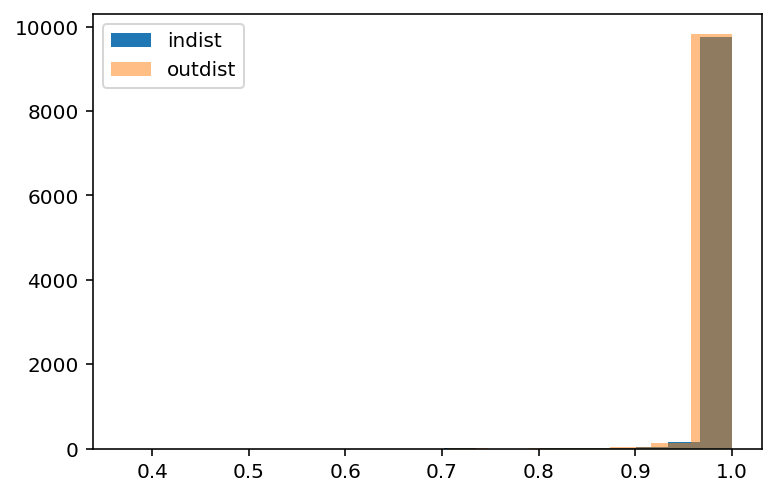

In [197]:
indist_conf = list()
outdist_conf = list()
for batch_in,batch_out in test_iter:
    with torch.no_grad():
        # Forward path
        mln_out = model.forward(batch_in.view(-1,3,32,32).to(device)) 
        pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
        out         = mln_gather(pi,mu,sigma)
        model_pred  = out['mu_sel'] # [B x N]
        value, ind = torch.max(model_pred,dim=1)
        indist_conf += list(value.cpu().numpy())

for batch_in,batch_out in svhn_test_iter:
    with torch.no_grad():
        # Forward path
        mln_out = model.forward(batch_in.view(-1,3,32,32).to(device)) 
        pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
        out         = mln_gather(pi,mu,sigma)
        model_pred  = out['mu_sel'] # [B x N]
        value, ind = torch.max(model_pred,dim=1)
        outdist_conf += list(value.cpu().numpy())
        

print(max(pi_dist), min(pi_dist))
plt.hist(indist_conf, bins=15, label='indist')
plt.hist(outdist_conf, alpha=0.5, bins=15, label='outdist')
plt.legend()

In [ ]:
pi_dist = list()
for batch_in,batch_out in train_iter:
    with torch.no_grad():
        # Forward path
        mln_out = model.forward(batch_in.view(-1,3,32,32).to(device)) 
        pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
        pi_dist += list(torch.argmax(pi,dim=1).cpu().numpy())
        
print(max(pi_dist), min(pi_dist))
plt.hist(pi_dist)

In [24]:
target[0,:], target[55, :]

(tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0'),
 tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0'))

In [32]:
pi[0,:] , pi[55,:]

(tensor([8.775e-05, 3.923e-05, 1.666e-05, 5.978e-06, 2.429e-05, 3.662e-01,
         3.904e-05, 9.873e-05, 5.053e-06, 2.849e-06, 1.674e-05, 1.002e-05,
         1.388e-05, 1.321e-05, 7.380e-06, 5.665e-06, 1.396e-04, 2.881e-05,
         6.357e-06, 6.332e-01, 2.221e-05, 2.288e-05, 2.282e-05, 2.741e-05],
        device='cuda:0', grad_fn=<SliceBackward>),
 tensor([2.775e-11, 5.936e-12, 1.078e-12, 1.825e-12, 2.190e-12, 6.231e-13,
         1.696e-12, 1.065e-11, 3.163e-13, 3.301e-13, 1.413e-12, 1.059e-12,
         1.414e-12, 1.350e-12, 1.322e-12, 7.133e-13, 1.996e-10, 2.677e-12,
         2.993e-13, 1.000e+00, 3.354e-12, 1.964e-12, 9.129e-13, 1.150e-12],
        device='cuda:0', grad_fn=<SliceBackward>))

In [25]:
sigma[0,:,:], sigma[55,:,:]

(tensor([[1.510, 1.001, 2.000, 2.000, 2.000, 2.000, 2.000, 2.000, 1.089, 1.006],
         [1.745, 1.738, 1.931, 1.964, 1.956, 1.911, 1.892, 1.933, 1.900, 1.756],
         [1.876, 1.859, 1.944, 1.967, 1.922, 1.962, 1.969, 1.928, 1.974, 1.619],
         [1.399, 1.002, 2.000, 1.999, 1.999, 1.994, 1.996, 1.999, 1.027, 1.001],
         [1.998, 1.997, 2.000, 2.000, 2.000, 1.999, 1.999, 2.000, 1.944, 1.998],
         [1.912, 1.864, 1.942, 1.873, 1.815, 1.824, 1.903, 1.903, 1.770, 1.792],
         [1.862, 1.836, 1.901, 1.947, 1.944, 1.919, 1.967, 1.873, 1.570, 1.806]],
        device='cuda:0', grad_fn=<SliceBackward>),
 tensor([[1.007, 1.004, 2.000, 2.000, 2.000, 2.000, 1.999, 2.000, 1.005, 1.009],
         [1.875, 1.666, 1.908, 1.917, 1.973, 1.914, 1.940, 1.956, 1.927, 1.880],
         [1.826, 1.824, 1.881, 1.959, 1.829, 1.916, 1.977, 1.936, 1.976, 1.808],
         [1.029, 1.037, 2.000, 1.999, 1.999, 1.998, 1.999, 1.999, 1.007, 1.065],
         [1.994, 1.994, 2.000, 2.000, 2.000, 2.000, 2.000

In [70]:
def func_eval_ood(model,data_iter,device):
    with torch.no_grad():
        n_total,n_correct,epis_unct_sum,alea_unct_sum = 0,0,0,0
        y_probs,y_trues= list(),list()
        epis_ = list()
        alea_ = list()
        model.eval() # evaluate (affects DropOut and BN)
        for batch_in,batch_out in data_iter:
            # Foraward path
            y_trgt      = batch_out.to(device)
            mln_out     = model.forward(batch_in.view(-1,3,32,32).to(device))
            pi,mu,sigma = mln_out['pi'],mln_out['mu'],mln_out['sigma']
            out         = mln_gather(pi,mu,sigma)
            model_pred  = out['mu_sel'] # [B x N]
 
            # Compute uncertainty 
            unct_out    = mln_uncertainties(pi,mu,sigma)
            epis_unct   = unct_out['epis'] # [N]
            alea_unct   = unct_out['alea'] # [N]
            epis_unct_sum += torch.sum(epis_unct)
            alea_unct_sum += torch.sum(alea_unct)

            # Check predictions
            
            _,y_pred = torch.max(model_pred,1)
            n_correct   += (y_pred==y_trgt).sum().item()
            n_total     += batch_in.size(0)
            
            epis_ += list(epis_unct.cpu().numpy())
            alea_ += list(alea_unct.cpu().numpy())
            
        val_accr  = (n_correct/n_total)
        epis      = (epis_unct_sum/n_total).detach().cpu().item()
        alea      = (alea_unct_sum/n_total).detach().cpu().item()
        model.train() # back to train mode 
        out_eval = {'val_accr':val_accr,'epis':epis,'alea':alea, 'epis_' : epis_,'alea_' : alea_, 'y_true':y_trues}
    return out_eval

Files already downloaded and verified


/home/rilab/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


20000 10000 10000


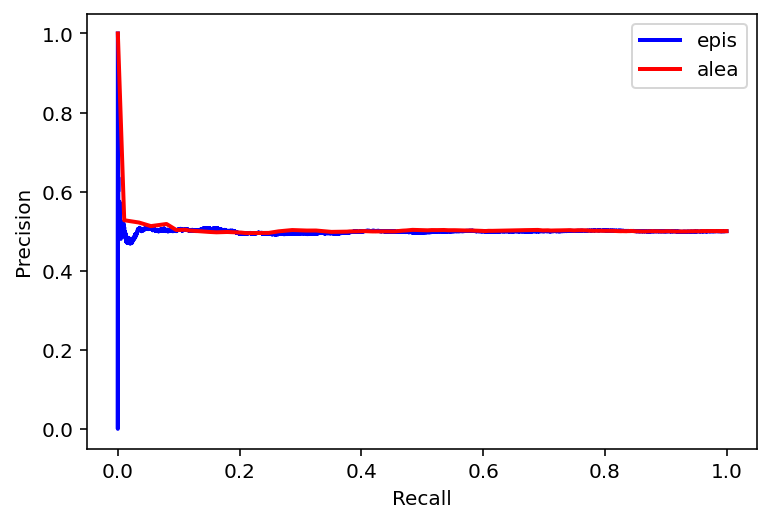

In [79]:
from sklearn.metrics import precision_recall_curve

plt.xlabel('Recall')
plt.ylabel('Precision')

#test_iter
cifar_res  = func_eval_ood(model,test_iter,device)
svhn_res  = func_eval_ood(model,svhn_test_iter,device)
y_true = [0 for i in range(len(cifar_res['epis_']))] + [1 for i in range(len(svhn_res['epis_']))]

print(len(y_true), len(cifar_res['epis_']), len(svhn_res['epis_']))

precision, recall, _   = precision_recall_curve(y_true,np.array(cifar_res['epis_']+ svhn_res['epis_']))
plt.plot(recall, precision, lw=2, c='b', label='epis')
precision, recall, _   = precision_recall_curve(y_true,np.array(cifar_res['alea_']+ svhn_res['alea_']))
plt.plot(recall, precision, lw=2, c='r', label='alea')
plt.legend()

plt.show()

In [78]:
y_true[-1]

0

NameError: name 'y_true' is not defined

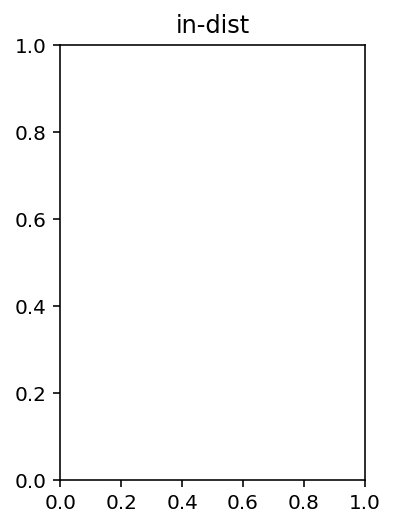

In [13]:
epis   = np.array(test_res['epis_'])
plt.subplot(1,2,1)
plt.title('in-dist')
plt.hist(epis[y_true == 0], bins=15, alpha=1 , color='r')
plt.subplot(1,2,2)
plt.title('out-of-dist')
plt.hist(epis[y_true == 1], bins=15,  alpha=0.3 , color='b')

In [ ]:
y_true = np.array(test_res['y_true'])
epis   = np.array(test_res['epis_'])
print(np.mean(epis[y_true == 0]), np.mean(epis[y_true == 1]))